In [2]:
import os
os.chdir(r"C:\Users\ashto\DAPPEr-main") #change directory to dapper-main folder
current_directory = os.getcwd()
print(f"Current directory: {current_directory}")

Current directory: C:\Users\ashto\DAPPEr-main


In [3]:
from src import *
from src.UDIP_Lib import *
import src.fitting.fit as R_fitting
import src.UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
from src.RockSat_json.RockSat_json import import_data
import numpy as np
from scipy import signal
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [4]:
def model(V, Vf, V0, VP,  b, m1, ne, te):
    I = np.zeros(len(V))
    I[V <= Vf] = lin(V[V <= Vf], m1) - lin(Vf, m1) + b
    Vtrans = (V > Vf) & (V < VP)
    I[Vtrans] = exp(V[Vtrans], ne, te, VP) + b
    I[V >  VP] = sqrt(V[V >  VP], ne, te, V0) - sqrt(VP, ne, te, V0) + b
    return I


def lin(x, m):#linear--full model square root
    return m * x


def exp(x, ne, te, V1):
    q_e = 1.602e-19  # Electron charge [C]
    K_b = 1.381e-23  # Boltzmann constant [J/K]
    m_e = 9.109e-31  # Electron mass [kg]
    R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
    L = 3.25 * 2.54  # Length of probe [cm]
    A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
    I0 = ne * q_e * np.sqrt(K_b * te/ (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
    k = q_e / (K_b * te)
    return I0 * np.exp(k * (x - V1))

def sqrt(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)

    arg = 1.0 + k * (x - V0)
    arg = np.where(arg >= 0, arg, 1)  # mask invalid regions

    return I0 * np.sqrt(arg)

def data_processing(x_raw, y_raw):
    x = np.nan_to_num(x_raw, nan=0.0, posinf=0.0, neginf=0.0)
    y = np.nan_to_num(y_raw, nan=0.0, posinf=0.0, neginf=0.0)
    return x, y


def gen_fit(x_raw,y_raw):
    x,y = data_processing(x_raw,y_raw)
    g = [2, 2, 2, -14, 80, 1.5*(10**10),200 ]    #intial guess
    b = [
        (-3,  -3, 2, -np.inf, -np.inf, 1, 50    ),
        ( 3,   3, 5, np.inf,  np.inf, 5*(10**10), 800 )
        ] #bounds
    popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b, maxfev=10000)
    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=1000)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

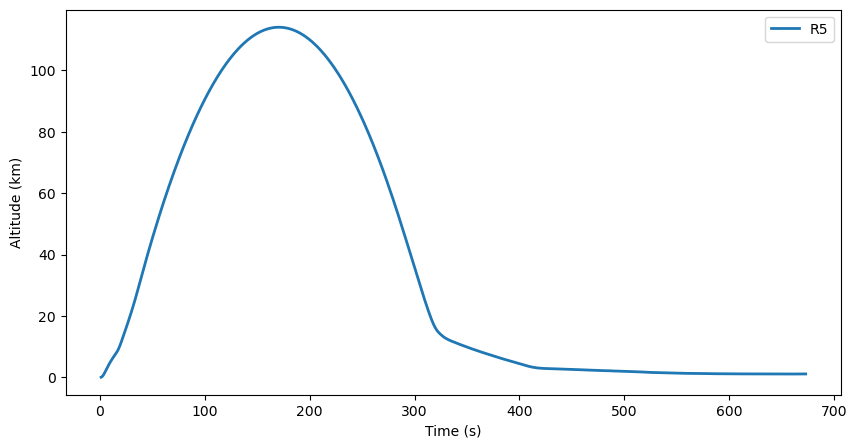

In [17]:
times3 = []
times5 = []
times10 = []
times18 = []
altitudes3 = []
altitudes5 = []
altitudes10 = []
altitudes18 = []
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R5 POSDAT 06202024.txt", "r") as rockonData5: #R5
    next(rockonData5)  # Skip the header
    for line in rockonData5:
        parts = line.strip().split()
        times5.append(float(parts[1]))  # time values
        altitudes5.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R3 POSDAT 06202024.txt", "r") as rockonData3: #R3
    next(rockonData3)  # Skip the header
    for line in rockonData3:
        parts = line.strip().split()
        times3.append(float(parts[1]))  # time values
        altitudes3.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R10 POSDAT 06202024.txt", "r") as rockonData10: #R10
    next(rockonData10)  # Skip the header
    for line in rockonData10:
        parts = line.strip().split()
        times10.append(float(parts[1]))  # time values
        altitudes10.append(float(parts[9]) / 1000)  # altitude values in km
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R18 POSDAT 06202024.txt", "r") as rockonData18:
    next(rockonData18)  # Skip the header
    for line in rockonData18:
        parts = line.strip().split()
        times18.append(float(parts[1]))  # time values
        altitudes18.append(float(parts[9]) / 1000)  # altitude values in km
apogee3 = max(altitudes3)
apogee5 = max(altitudes5)
apogee10 = max(altitudes10)
apogee18 = max(altitudes18)
plt.figure(figsize=(10, 5))
# plt.plot(times3, altitudes3, label= "R3", lw=2)
plt.plot(times5, altitudes5, label= "R5",lw=2) #i am using these values for data analysis
# plt.plot(times10, altitudes10, label= "R10",lw=2)
# plt.plot(times18, altitudes18, label= "R18",lw=2, ls='--')
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.legend()
# plt.axvline(200)
# plt.axvline(140)
# plt.axhline(109)
# plt.xlim(100,250)
plt.show()
#looks like R3,R10 messed up until t=100s, then they all make the same shape, 
# R5 and R18 look very similar, I am arbitrarily using R5 for analysis

In [6]:
packets = import_data('data/packets/UDIP_4_800s.json')
ne = np.array([])
Te = np.array([])
temp_error = np.array([])
dens_error = np.array([])
Imax = np.array([])
t_lin = np.array([])
starting_sweep = 170
stopping_sweep = 475 #170-475 are where we get good data roughly
st = packets['packets']['Full'][f'{starting_sweep}']['Start']
fin = packets['packets']['Full'][f'{stopping_sweep}']['Start']
step   = 1

for sweep in range(starting_sweep, stopping_sweep, step):
#get sweep data from packets
    c = 7
    V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]) 
    I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
    Vfit, Ifit, popt, pcov = gen_fit(V, I) #fit it
#time data from packets
    start = packets['packets']['Full'][f'{sweep}']['Start']
    stop  = packets['packets']['Full'][f'{sweep}']['Stop']
    t_lin = np.append(t_lin, (start + stop)/2/1000 - 57)
#densities and temperatures
    ne = np.append(ne,popt[5])
    Te = np.append(Te,popt[6])
    ne_std = np.sqrt(pcov[5,5])
    Te_std = np.sqrt(pcov[6, 6])
    temp_error = np.append(temp_error,Te_std)
    dens_error = np.append(dens_error,ne_std)

    # #For the bad values, cut IV to get just the top branch of it, hopefully yields better temperatures
    # if(Te[-1] >= 2000):
    #     FirstFitTe = Te[-1]
    #     midpoint = len(V) // 2  # Find the middle of the sweep
    #     V_new = V[midpoint:]  # Take only the second half
    #     I_new = I[midpoint:]
    #     Vfit, Ifit, popt, pcov = gen_fit(V_new, I_new)

    #     #overwrite the Te and ne values with the new fit results
    #     Te[-1] = popt[6]
    #     if Te[-1] >= 2000:
    #         print(f"Warning: Sweep {sweep} still has Te >= 2000 (Te = {Te[-1]}) after second fit, went from {FirstFitTe} -> {Te[-1]}")
    #     ne[-1] = popt[5]
    #print(f"Sweep #: {sweep}")
    Imax = np.append(Imax, np.max(I))
ne = ne * 1e-6 #go to cm^-3

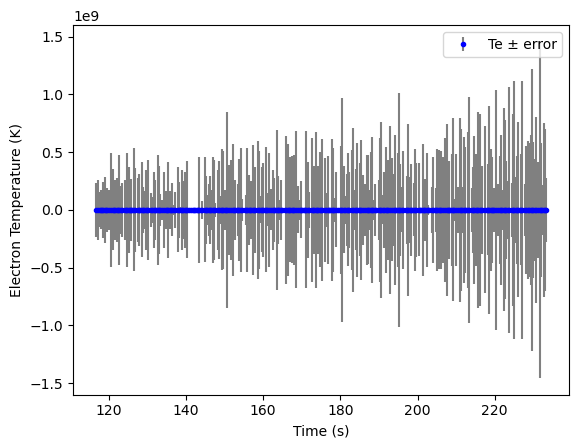

In [7]:
plt.errorbar(t_lin, Te, yerr=temp_error, fmt='.',color='blue',ecolor='grey', label='Te ± error')
plt.xlabel("Time (s)")
plt.ylabel("Electron Temperature (K)")
plt.legend()
plt.show()

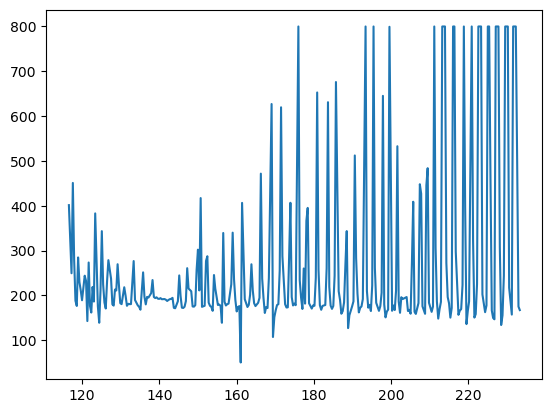

In [8]:
plt.plot(t_lin,Te)

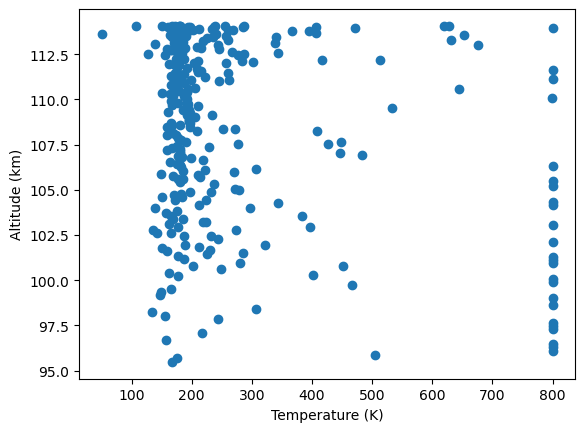

In [9]:
altitude_function = interp1d(times5, altitudes5) 
interpolated_altitudes = altitude_function(t_lin) # Make altitude array based on time values from IV data
#plt.xlim(0,1000)
plt.scatter(Te, interpolated_altitudes) # this is both ascending and descending, want to separate
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (km)")



apogee_value = np.where(interpolated_altitudes == apogee5)[0][0] #cutting list at apogee to find temperatures going up


In [10]:
from scipy.stats import binned_statistic
def bin_average_scipy(x, y, binsize=1.0):
    """
    Computes the average of x-values binned by y-values using scipy's binned_statistic.
    Parameters
    ----------
    x : array-like
        The dependent variable to average (temperature or density)
    y : array-like
        The independent variable to bin by (altitude).
    binsize : float, optional
        Width of each bin along the y-axis. Default is 1.0.

    Returns
    -------
    x_avg : np.ndarray
        Array of average x-values for each bin.
    y_bin_centers : np.ndarray
        Center points of the y-axis bins, suitable for plotting on the y-axis.
    """
    y_bins = np.arange(min(y), max(y) + binsize, binsize) 
    stat, bin_edges, _ = binned_statistic(y, x, statistic='median', bins=y_bins) #using median for the red line, mean gets wacky for the noisier plots
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return stat, bin_centers

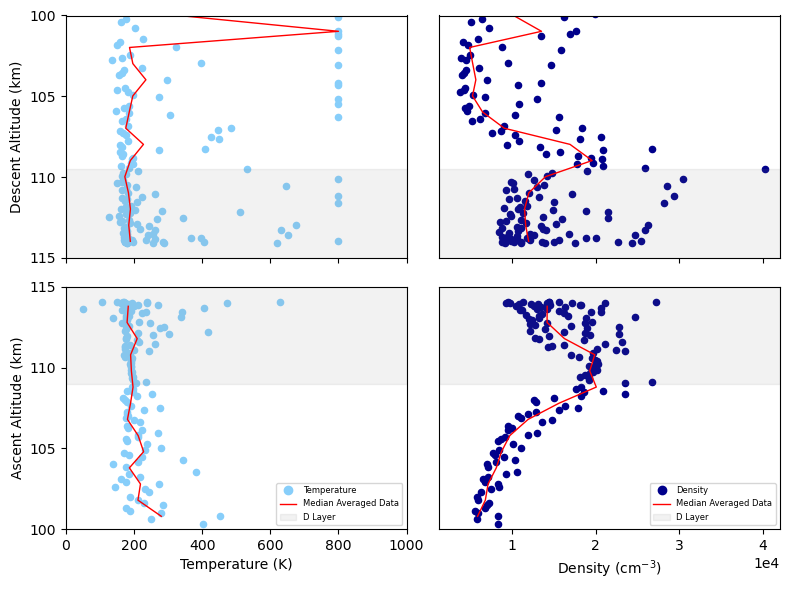

In [11]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches
fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(8, 6))

#left side is temperature
axes[1, 0].scatter(Te[:apogee_value], interpolated_altitudes[:apogee_value], label='Ascending', s=20, color='lightskyblue') #[1,0] is bottom left
axes[0, 0].scatter(Te[apogee_value:], interpolated_altitudes[apogee_value:], label='Descending',s=20, color='lightskyblue') #[0,0] top left

axes[1, 0].set_xlabel('Temperature (K)')
axes[1, 0].set_ylabel('Ascent Altitude (km)')
axes[0, 0].set_ylabel('Descent Altitude (km)')

#right density
axes[1, 1].scatter(ne[:apogee_value], interpolated_altitudes[:apogee_value], label='Ascending',s=20, color='darkblue') #[1,1] bottom right
axes[0, 1].scatter(ne[apogee_value:], interpolated_altitudes[apogee_value:], label='Descending',s=20,color='darkblue')#[0,1] top right

axes[1, 1].set_xlabel(r'Density (cm$^{-3})$')

for ax in [axes[0, 1], axes[1, 1]]: #Remove y-axis labels and ticks from right-side plots
    ax.set_ylabel("")  
    ax.yaxis.set_tick_params(left=False, labelleft=False)

#tickmarks every 5 km to make it look neater
y_min, y_max = 100, 115
for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_ylim(y_min, y_max)
    ax.yaxis.set_major_locator(MultipleLocator(5)) #tickmark every 5


for ax in [axes[0, 1], axes[1, 1]]:
    ax.set_ylim(y_min, y_max)
# Set scientific notation for the x-axis of the density plots for neatness
for ax in [axes[0, 1], axes[1, 1]]:
    formatter = ScalarFormatter()
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    ax.xaxis.set_major_formatter(formatter)


#temp averages
Te_asc_avg, alt_asc_avg = bin_average_scipy(Te[:apogee_value], interpolated_altitudes[:apogee_value])
Te_desc_avg, alt_desc_avg = bin_average_scipy(Te[apogee_value:], interpolated_altitudes[apogee_value:])

axes[1, 0].plot(Te_asc_avg, alt_asc_avg, color='red', linewidth=1)
axes[0, 0].plot(Te_desc_avg, alt_desc_avg, color='red', linewidth=1)

# Density avg
ne_asc_avg, alt_asc_avg2 = bin_average_scipy(ne[:apogee_value], interpolated_altitudes[:apogee_value])
ne_desc_avg, alt_desc_avg2 = bin_average_scipy(ne[apogee_value:], interpolated_altitudes[apogee_value:])

axes[1, 1].plot(ne_asc_avg, alt_asc_avg2, color='red', linewidth=1)
axes[0, 1].plot(ne_desc_avg, alt_desc_avg2, color='red', linewidth=1)

# shading E layer
for ax in axes[0, :]:  #descent plots ([0, 0] & [0, 1])
    ax.axhspan(109.5, 116, color='gray', alpha=0.1)

for ax in axes[1, :]:  #ascent [1, 0] & [1, 1])
    ax.axhspan(109, 116, color='gray', alpha=0.1)

#legend
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
e_layer_patch = mpatches.Patch(color='gray', alpha=0.1, label='D Layer')
median_line = Line2D([0], [0], color='red', linewidth=1, label='Median Averaged Data')
temp_scatter = Line2D([0], [0], marker='o', color='lightskyblue', linestyle='None', markersize=6, label='Temperature')
density_scatter = Line2D([0], [0], marker='o', color='darkblue', linestyle='None', markersize=6, label='Density')

axes[1,0].legend(handles=[temp_scatter, median_line, e_layer_patch], loc='lower right', fontsize=6)
axes[1,1].legend(handles=[density_scatter, median_line, e_layer_patch], loc='lower right',fontsize=6)



axes[0,0].set_xlim(0, 1000)
axes[0,0].invert_yaxis()
axes[0,1].invert_yaxis()
#axes[0,1].axhline(109)
#axes[1,1].axhline(109)
plt.tight_layout()
plt.show()

In [12]:
perr = np.sqrt(np.diag(pcov))
print(perr)


[6.40852464e+06 2.38885892e+04 1.36369972e+05 3.92939162e+07
 1.33991965e+00 2.72113384e+08 2.77114288e+08]
